In [1]:
import pandas as pd
import sys
sys.path.append('..')
import db
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np


In [ ]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [2]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _201904 where monthly_salary>0 and monthly_salary<15", con=conn)
conn.close()

In [3]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [4]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [5]:
def get_sub_stats(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    count=[]
    for feature in features:
        salary_mean.append(data[data[feature]==1].monthly_salary.mean()*10000)
        salary_median.append(data[data[feature]==1].monthly_salary.median()*10000)
        count.append(data[data[feature]==1].shape[0])
    sub_data=pd.DataFrame()
    sub_data[prefix]=[f.replace(prefix,'') for f in features]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

In [8]:
data_city=get_sub_stats(data,'city_')
data_city.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,17453,15000,13823,9.90%
17,shanghai,16626,15000,25888,18.55%
19,shenzhen,15631,14000,20757,14.87%
9,hangzhou,14977,12500,8690,6.23%
8,guangzhou,13032,12000,17068,12.23%
14,nanjing,12874,12500,7091,5.08%
3,chengdu,11896,11500,7028,5.04%
6,dongguan,11353,10417,1632,1.17%
22,xian,11075,10000,3833,2.75%
21,wuhan,11074,10417,8027,5.75%


程序员收入最高的城市分别为：北京，上海，深圳，广州

In [9]:
translate_dict={}
translate_dict['beijing']='北京'
translate_dict['shanghai']='上海'
translate_dict['shenzhen']='深圳'
translate_dict['hangzhou']='杭州'
translate_dict['guangzhou']='广州'
translate_dict['nanjing']='南京'
translate_dict['chengdu']='成都'
translate_dict['dongguan']='东莞'
translate_dict['xian']='西安'
translate_dict['wuhan']='武汉'
translate_dict['tianjin']='天津'
translate_dict['changsha']='长沙'
translate_dict['ningbo']='宁波'
translate_dict['fuzhou']='福州'
translate_dict['dalian']='大连'
translate_dict['chongqing']='重庆'
translate_dict['qingdao']='青岛'
translate_dict['jinan']='济南'
translate_dict['hefei']='合肥'
translate_dict['changchun']='长春'
translate_dict['kuming']='昆明'
translate_dict['zhengzhou']='郑州'
translate_dict['shenyang']='沈阳'
translate_dict['harbin']='哈尔滨'


In [165]:
data_location = pd.read_csv('city_locations.csv')
data_location=data_location.set_index('city')

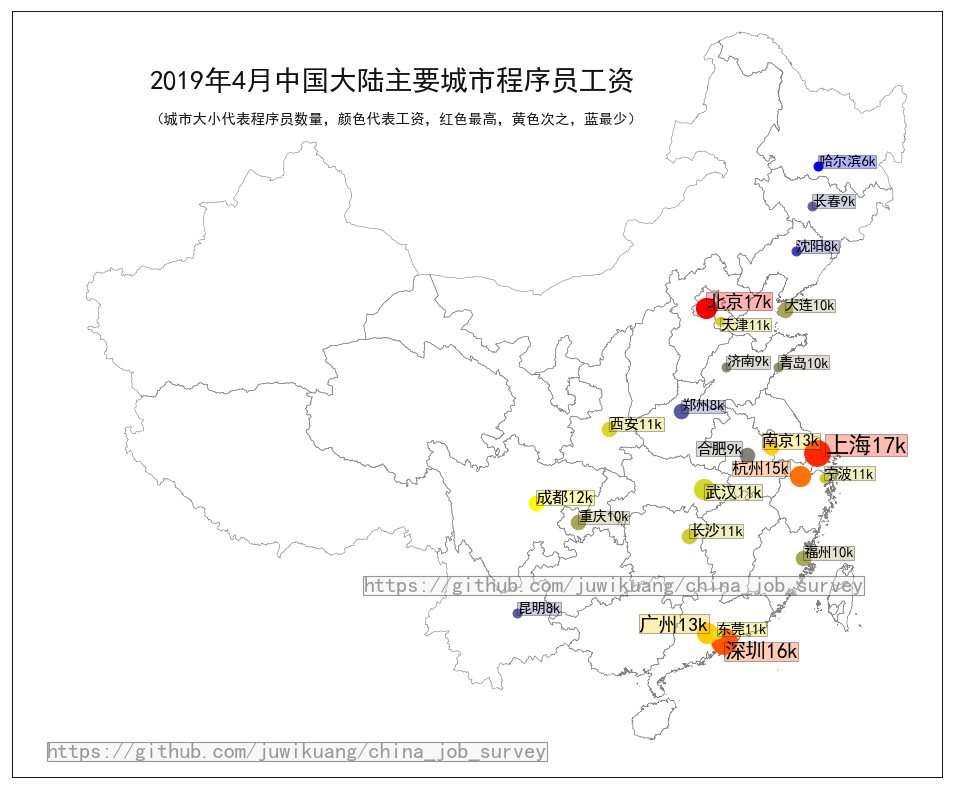

In [166]:

from mpl_toolkits.basemap import Basemap

#cities = []
scale = 5

locations = [(116.407526, 39.90403),(120, 30)]
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [15, 15]
#plt.figure(figsize = (10,5))
fig, ax = plt.subplots()
fig.title='中国大陆主要城市程序员工资'
fig.figsize=(10,5)
fig.dpi=80
cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
           projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

# load the shapefile, use the name 'states'
cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='states', drawbounds=True, color='gray')
cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
#geolocator = Nominatim(user_agent="my-application")


    
salary_min=data_city.salary_mean.min()
salary_max=data_city.salary_mean.max()
salary_middle = (salary_min+salary_max)/2
salary_scale=salary_max-salary_min
    
for index, row in data_city.iterrows():
    city=row[0]
    city_cn=translate_dict[city]
    longitude = data_location.loc[city_cn,'longitude']
    latitude = data_location.loc[city_cn,'latitude']
    salary=row[1]
    headcount=row[3]
    #color
    color_red=0
    color_green=0
    color_blue=0
    if salary>salary_middle:
        color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
        color_green = int((salary_max - salary) / (salary_scale/2)*255)
    else:
        color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
        color_green = int((salary - salary_min) / (salary_scale/2)*255)
        color_red = int((salary - salary_min) / (salary_scale/2)*255)
    
    color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)
        
    
    x, y = cn_map(longitude,latitude)
    cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/2000))*scale+8)
    #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
    #"{}{:.0f}".format(city_cn, salary)
    #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
    fontsize=int(headcount/3000+13)
    if city == 'hangzhou':
        x=x-400000
        y=y+10000
    elif city=='guangzhou':
        x=x-400000
        y=y+10000
    elif city=='hefei':
        x=x-300000
        y=y+10000
    elif city=='shenzhen':
        y=y-100000
    elif city=='nanjing':
        x=x-50000
    elif city=='tianjin':
        y=y-50000
    elif city=='shanghai':
        x=x+50000
    elif city=='wuhan':
        y=y-50000
        
    ax.text(x, y, "{}{:.0f}k".format(city_cn, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
ax.text(805805, 4007845, "2019年4月中国大陆主要城市程序员工资".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
ax.text(805805, 3807845, "（城市大小代表程序员数量，颜色代表工资，红色最高，黄色次之，蓝最少）".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=13)    
#cn_map.drawcoastlines() #绘制海岸线
#cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
plt.show()
